In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score, confusion_matrix, classification_report
from keras.utils import Sequence
from keras.utils import to_categorical
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
from keras.layers import Dropout
from keras.utils import np_utils
from keras.losses import binary_crossentropy, categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

IMG_SIZE = 256
NUM_CLASSES = 5
SEED = 26

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## Create a training Dataframe

In [3]:
train_dir = os.path.join('/kaggle/input','train_images/')
df = pd.read_csv(os.path.join('/kaggle/input', 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
# df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,id_code,diagnosis,path
0,a0b7ad98df57,0,/kaggle/input/train_images/a0b7ad98df57.png
1,932181b93b2f,2,/kaggle/input/train_images/932181b93b2f.png
2,435414ccccf7,0,/kaggle/input/train_images/435414ccccf7.png
3,29d059522fa1,0,/kaggle/input/train_images/29d059522fa1.png
4,286e9981dd9b,0,/kaggle/input/train_images/286e9981dd9b.png
5,6d9effbcde78,0,/kaggle/input/train_images/6d9effbcde78.png
6,c5a9ebef1517,3,/kaggle/input/train_images/c5a9ebef1517.png
7,6c315ad3d07f,2,/kaggle/input/train_images/6c315ad3d07f.png
8,dc0eea0b68a7,0,/kaggle/input/train_images/dc0eea0b68a7.png
9,0dbaa09a458c,2,/kaggle/input/train_images/0dbaa09a458c.png


In [4]:
df_bin_train = df

In [5]:
# change diagnosis to binary model
df_bin_train['diagnosis'] = df_bin_train['diagnosis'].map({0:0, 1: 1, 2: 1, 3: 1, 4: 1})

In [6]:
df_bin_train.head()

,id_code,diagnosis,path
0,a0b7ad98df57,0,/kaggle/input/train_images/a0b7ad98df57.png
1,932181b93b2f,1,/kaggle/input/train_images/932181b93b2f.png
2,435414ccccf7,0,/kaggle/input/train_images/435414ccccf7.png
3,29d059522fa1,0,/kaggle/input/train_images/29d059522fa1.png
4,286e9981dd9b,0,/kaggle/input/train_images/286e9981dd9b.png


## Train, Test, Split with validation split at 0.15

Since the training set is limited, we'll use a smaller size for the validation set

In [7]:
(train, valid) = train_test_split(df_bin_train, test_size=549, random_state=SEED)

In [8]:
len(train)

3113

In [9]:
len(valid)

549

## Testing DF for export to kaggle

In [10]:
test_dir = os.path.join('/kaggle/input','test_images/')
test_df = pd.read_csv(os.path.join('/kaggle/input', 'test.csv'))
test_df['path'] = test_df['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
# test_df = test_df.drop(columns=['id_code'])
# test_df = test_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
test_df.head(10)

,id_code,path
0,0005cfc8afb6,/kaggle/input/test_images/0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/test_images/003f0afdcd15.png
2,006efc72b638,/kaggle/input/test_images/006efc72b638.png
3,00836aaacf06,/kaggle/input/test_images/00836aaacf06.png
4,009245722fa4,/kaggle/input/test_images/009245722fa4.png
5,009c019a7309,/kaggle/input/test_images/009c019a7309.png
6,010d915e229a,/kaggle/input/test_images/010d915e229a.png
7,0111b949947e,/kaggle/input/test_images/0111b949947e.png
8,01499815e469,/kaggle/input/test_images/01499815e469.png
9,0167076e7089,/kaggle/input/test_images/0167076e7089.png


In [11]:
# cast 'diagnosis' as type string
df_bin_train['diagnosis'] = df_bin_train['diagnosis'].astype('str')
df_bin_train['diagnosis'].value_counts(normalize=True)

1    0.5071
0    0.4929
Name: diagnosis, dtype: float64

In [12]:
train['diagnosis'] = train['diagnosis'].astype('str')
valid['diagnosis'] = valid['diagnosis'].astype('str')

In [13]:
df_bin_train.head()

,id_code,diagnosis,path
0,a0b7ad98df57,0,/kaggle/input/train_images/a0b7ad98df57.png
1,932181b93b2f,1,/kaggle/input/train_images/932181b93b2f.png
2,435414ccccf7,0,/kaggle/input/train_images/435414ccccf7.png
3,29d059522fa1,0,/kaggle/input/train_images/29d059522fa1.png
4,286e9981dd9b,0,/kaggle/input/train_images/286e9981dd9b.png


## Display Samples

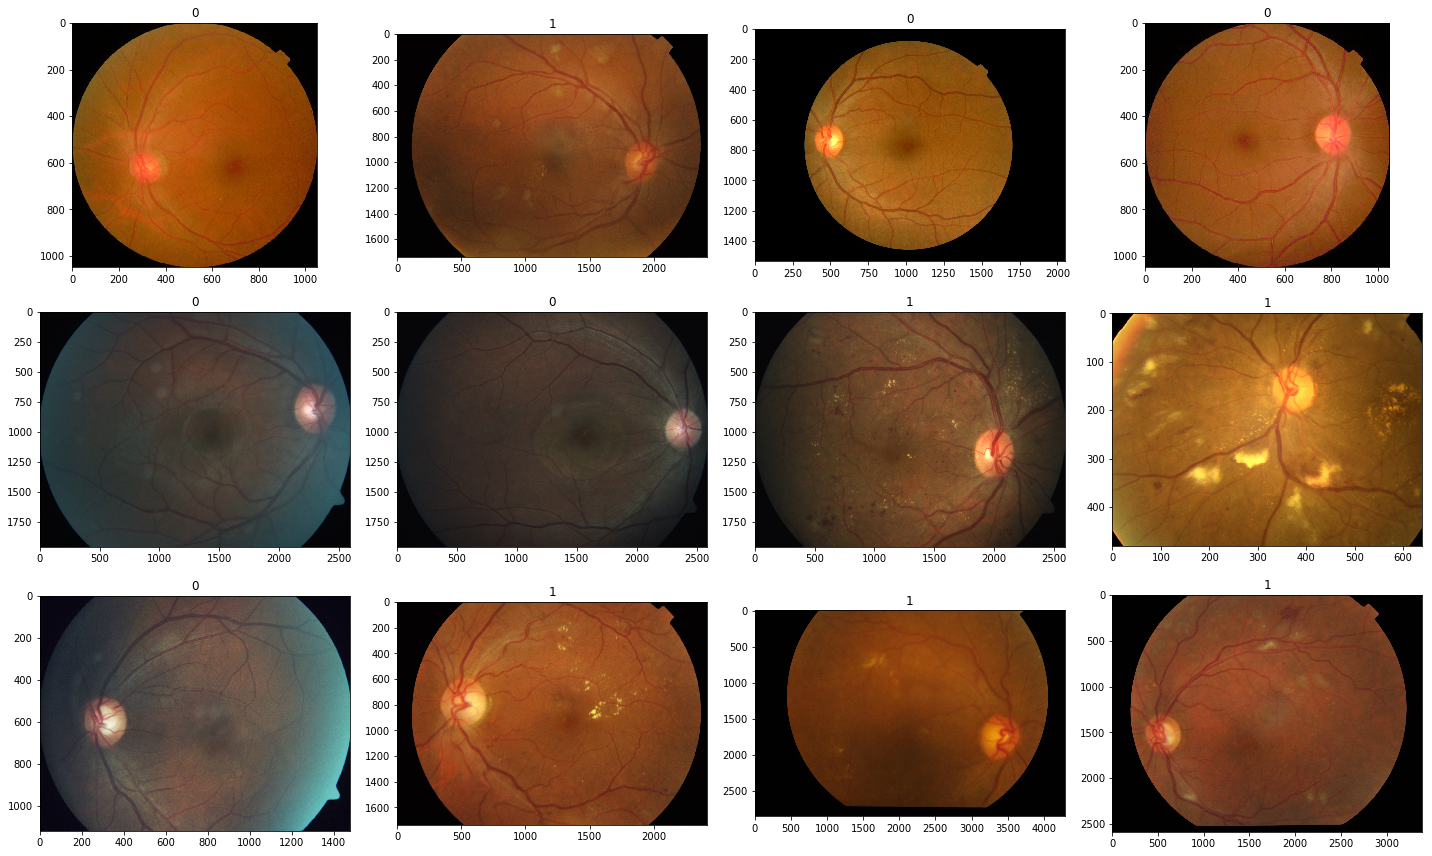

In [15]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'path']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(df)

In [16]:
total_count = df_bin_train['diagnosis'].sum()

In [17]:
df_bin_train['diagnosis'].unique()

array(['0', '1'], dtype=object)

In [18]:
# class weight used on non-binary model
# class_weight = class_weight.compute_class_weight('balanced',['0', '1', '2', '3', '4'],df['diagnosis'])
# class_weight = {0: -0.601, 1: -0.392, 2: -.833, 3: 0.164, 4: 1.662}
# class_weight = {0: 0.205913, 1: 0.130705, 2: 0.568465, 3: 0.052703, 4: 0.080557}

## ImageDataGenerator

Used to introduce noise and rescale images.

In [21]:
datagen=ImageDataGenerator(featurewise_center=True,
                           featurewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           rescale=1./255.)

In [22]:
# does not rescale validation images
datagen2 = ImageDataGenerator(featurewise_center=True,
                           featurewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True)

In [23]:
# seq.augment_image(datagen)

## Create a train, validation, and testing generator

In [24]:
train_generator = datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory=None,
                                            x_col="path",
                                            y_col="diagnosis",
#                                             subset="training",
                                            batch_size=32,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="binary",
                                            interpolation="bilinear",
                                            target_size=(IMG_SIZE, IMG_SIZE))
valid_generator = datagen2.flow_from_dataframe(
                                            dataframe=valid,
                                            directory=None,
                                            x_col="path",
                                            y_col="diagnosis",
#                                             subset="validation",
                                            batch_size=1,
                                            seed=SEED,
                                            shuffle=False,
                                            class_mode="binary",
                                            interpolation="bilinear",
                                            target_size=(IMG_SIZE, IMG_SIZE))
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test_df,
                                            directory=None,
                                            x_col="path",
                                            y_col=None,
                                            batch_size=32,
                                            seed=SEED,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE))

Found 3113 validated image filenames belonging to 2 classes.
Found 549 validated image filenames belonging to 2 classes.
Found 1928 validated image filenames.


In [25]:
y_test = np_utils.to_categorical(valid_generator.classes, 2)

In [26]:
len(y_test)

549

In [27]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
len(valid_generator.classes)

549

## Callbacks

Create and define callbacks for the model

In [29]:
# method to define kaggle quadratic weighted kappa score

from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
#                                                   steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  steps=18,
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            try:
                score = cohen_kappa_score(self.y_val,
                                          flatten(y_pred),
                                          labels=[0,1,2,3,4],
                                          weights='quadratic')
                
                print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
                self.history.append(score)
                if score >= max(self.history):
                    print('saving checkpoint: ', score)
                    self.model.save('../working/densenet_bestqwk.h5')
            except:
                pass

qwk = QWKEvaluation(validation_data=(valid_generator, valid_generator.classes), batch_size=64, interval=1)

In [30]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [31]:
# callbacks list

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)
checkpoint = ModelCheckpoint('../working/densenet_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

In [32]:
# define metrics for model evaluation
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [33]:
# get the step sizes

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

## Instantiate model and create convolutions

In [34]:
# add convolutions

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.4))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(Dropout(0.4))
model.add(layers.BatchNormalization())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 61, 32)        0         
__________

In [35]:
# add dense layers

model.add(layers.Flatten()) #flatten 3D outputs to 1D
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
# model.add(layers.Dense(64, activation='relu'))
# model.add(Dropout(rate=0.5))
# model.add(layers.Dense(32, activation='relu'))
# model.add(Dropout(rate=0.5))
model.add(layers.Dense(1, activation='sigmoid')) # 5 outputs

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 61, 32)        0         
__________

## Compile the model

In [37]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
#               loss='categorical_crossentropy',
#               loss=kappa_loss,
              metrics=["acc"])

In [38]:
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]

## Fit the model

In [39]:
# fit the model
# commented out code for small trial set
history = model.fit_generator(generator=train_generator,
#                               steps_per_epoch=2,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
#                               validation_steps=2,
                              validation_steps=STEP_SIZE_VALID,
                              class_weight='balanced',
                              epochs=30,
                              verbose=1,
                              callbacks=callbacks_list
)

Epoch 1/30
97/97 [==============================] - 483s 5s/step - loss: 0.9343 - acc: 0.5995 - val_loss: 0.7106 - val_acc: 0.6248

Epoch 00001: val_loss improved from inf to 0.71062, saving model to ../working/densenet_.h5
Epoch 2/30
97/97 [==============================] - 417s 4s/step - loss: 0.6021 - acc: 0.6688 - val_loss: 0.9368 - val_acc: 0.5501

Epoch 00002: val_loss did not improve from 0.71062
Epoch 3/30
97/97 [==============================] - 414s 4s/step - loss: 0.5433 - acc: 0.7256 - val_loss: 0.8984 - val_acc: 0.6393

Epoch 00003: val_loss did not improve from 0.71062
Epoch 4/30
97/97 [==============================] - 425s 4s/step - loss: 0.4506 - acc: 0.7918 - val_loss: 0.6264 - val_acc: 0.6721

Epoch 00004: val_loss improved from 0.71062 to 0.62643, saving model to ../working/densenet_.h5
Epoch 5/30
97/97 [==============================] - 410s 4s/step - loss: 0.3910 - acc: 0.8291 - val_loss: 0.4220 - val_acc: 0.7796

Epoch 00005: val_loss improved from 0.62643 to 0.4

In [40]:
len(valid_generator.filenames)

549

## Generate Predictions

In [41]:
prediction = model.predict_generator(valid_generator, steps=549, verbose=1)

549/549 [==============================] - 74s 134ms/step


In [42]:
prediction

array([[9.87404466e-01],
       [4.80150959e-07],
       [9.97049153e-01],
       [7.77575001e-02],
       [7.53093047e-07],
       [3.59082310e-06],
       [9.99197304e-01],
       [4.64831710e-01],
       [9.52187359e-01],
       [1.43037736e-01],
       [1.49378315e-01],
       [9.89954352e-01],
       [0.00000000e+00],
       [1.82134390e-01],
       [9.94463623e-01],
       [9.90470529e-01],
       [8.73162523e-02],
       [8.67981672e-01],
       [9.86147583e-01],
       [9.65768278e-01],
       [9.99984622e-01],
       [2.27483377e-01],
       [0.00000000e+00],
       [9.60731506e-01],
       [6.88423455e-01],
       [9.62995529e-01],
       [5.85491352e-06],
       [4.13290560e-01],
       [1.32162303e-01],
       [9.99998569e-01],
       [2.64790893e-01],
       [0.00000000e+00],
       [2.01904371e-01],
       [9.93002951e-01],
       [9.92954195e-01],
       [9.63581130e-02],
       [1.08410731e-01],
       [9.99931931e-01],
       [9.79208410e-01],
       [2.73699164e-01],


In [43]:
# change probability to class predictions
pred = []
for i in prediction:
    for j in i:
        if j > 0.5:
            pred.append(1)
        else:
            pred.append(0)

In [44]:
pred

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


## Evaluate the Model

In [48]:
model.metrics_names

['loss', 'acc']

In [49]:
# evaluate the model
model.evaluate_generator(generator=valid_generator,
                         steps=STEP_SIZE_TEST,
                         verbose=1)

60/60 [==============================] - 7s 122ms/step


[0.2984667071155183, 0.8333333333333334]

## Plot Accuracy and Loss

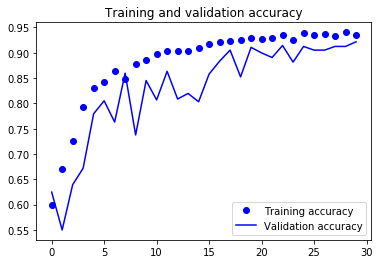

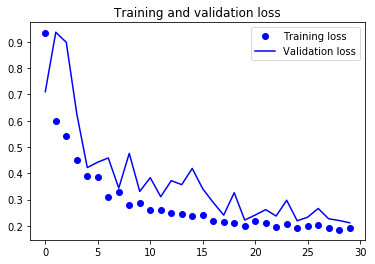

In [50]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()